In [1]:
import numpy as np  
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline

In [2]:
id_col_names = ['user_id','coupon_id','date_received']
target_col_name = 'label'
id_target_cols = ['user_id','coupon_id','date_received','label']
myeval = 'roc_auc'
cvscore = 0

datapath = 'C:/Users/Stille/Desktop/ML projects/' 
featurepath = 'C:/Users/Stille/Desktop/ML projects/feature/' 
resultpath = 'C:/Users/Stille/Desktop/ML projects/result/'
tmppath = 'C:/Users/Stille/Desktop/ML projects/tmp/'
scorepath = 'C:/Users/Stille/Desktop/ML projects/score/'

In [3]:
# return id columns
def get_id_df(df):
    return df[id_col_names]

# return target column
def get_target_df(df):
    return df[target_col_name]

# return predictor columns
def get_predictors_df(df):
    predictors = [f for f in df.columns if f not in id_target_cols]
    return df[predictors]

# read train data based on feature names
def read_featurefile_train(featurename): 
    df = pd.read_csv(featurepath+'train_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

# read test data based on feature names
def read_featurefile_test(featurename): 
    df = pd.read_csv(featurepath+'test_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

# read data based on feature names
def read_data(featurename): 
    traindf = read_featurefile_train(featurename)
    testdf = read_featurefile_test(featurename)
    return traindf, testdf  

In [4]:
# scaling
def standize_df(train_data, test_data):
    from sklearn import preprocessing 
    
    features_columns = [f for f in test_data.columns if f not in id_target_cols]
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler = min_max_scaler.fit(train_data[features_columns])
    
    train_data_scaler = min_max_scaler.transform(train_data[features_columns])
    test_data_scaler = min_max_scaler.transform(test_data[features_columns])
    
    train_data_scaler = pd.DataFrame(train_data_scaler)
    train_data_scaler.columns = features_columns
    
    test_data_scaler = pd.DataFrame(test_data_scaler)
    test_data_scaler.columns = features_columns
    
    train_data_scaler['label'] = train_data['label']
    train_data_scaler[id_col_names] = train_data[id_col_names]
    test_data_scaler[id_col_names] = test_data[id_col_names]
    return train_data_scaler,test_data_scaler

In [5]:
# sklearn models
def get_sklearn_model(model_name):
    # naive Bayes
    if model_name == 'NB':
        return MultinomialNB(alpha = 0.01)
    # logistic regression
    elif model_name == 'LR':
        return LogisticRegression(penalty = 'l2')
    # KNN
    elif model_name == 'KNN':
        return KNeighborsClassifier()
    # decision tree
    elif model_name == 'DT':
        return tree.DecisionTreeClassifier()
    # random forest
    elif model_name == 'RF':
        return RandomForestClassifier()
    # SVM
    elif model_name == 'SVC':
        return SVC(kernel = 'rbf')
    # GBDT
    elif model_name == 'GBDT':
        return GradientBoostingClassifier()
    # XGBoost
    elif model_name == 'XGB':
        return XGBClassifier(eval_metric = "auc")
    # lightGBM
    elif model_name == 'LGB':
        return LGBMClassifier()
    else:
        print("wrong model name!")


# plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=[0.01,0.02,0.05,0.1,0.2,0.3]):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv,scoring=myeval, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt


# plot learning curve of models
def plot_curve_single(traindf,classifier,cvnum,train_sizes=[0.01,0.02,0.05,0.1,0.2,0.3]): 
    X = get_predictors_df(traindf)
    y = get_target_df(traindf)
    estimator = get_sklearn_model(classifier)
    title = "learning curve of "+classifier+", cv:"+str(cvnum)
    plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cvnum, train_sizes=train_sizes)


# auc eval
def myauc(test):
    testgroup = test.groupby(['coupon_id'])
    aucs = []
    for i in testgroup:
        coupon_df = i[1]
        if len(coupon_df['label'].unique()) < 2:
            continue
        auc = metrics.roc_auc_score(coupon_df['label'], coupon_df['pred'])
        aucs.append(auc)
    return np.average(aucs)

# split by date
def test_model(traindf, classifier):
    train = traindf[traindf.date_received<20160515].copy()
    test = traindf[traindf.date_received>=20160515].copy()

    train_data = get_predictors_df(train).copy()
    train_target = get_target_df(train).copy()
    test_data = get_predictors_df(test).copy()
    test_target = get_target_df(test).copy()
    
    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result = clf.predict_proba(test_data)[:,1]
    test['pred'] = result
    score = metrics.roc_auc_score(test_target, result)
    print(classifier+" total AUC:", score)
    score_coupon = myauc(test)
    print(classifier+" Coupon AUC:", score_coupon)


def test_model_split(traindf,classifier):
    
    target = get_target_df(traindf).copy()
    
    train_all,test_all,train_target,test_target = train_test_split(traindf,target,test_size=0.2,random_state=0)
    
    train_data = get_predictors_df(train_all).copy()
    test_data = get_predictors_df(test_all).copy()
    
    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result = clf.predict_proba(test_data)[:,1]
    
    test = test_all.copy()
    test['pred'] = result
    
    score = metrics.roc_auc_score(test_target, result)
    print(classifier+"total AUC:", score)
    score_coupon = myauc(test)
    print(classifier+" Coupon AUC:", score_coupon)




In [6]:
train_f1,test_f1 = read_data('f1')
train_f1,test_f1 = standize_df(train_f1,test_f1)


In [7]:
train_f1.shape

(304509, 9)

In [8]:
train_f1['label'].sum()

27878

In [9]:
train_f1.head()

,discount_rate,distance,if_fd,full_value,reduction_value,label,user_id,coupon_id,date_received
0,0.812785,0.1,1.0,0.500000,0.20,0,1439408,11002,20160528
1,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160613
2,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160516
3,0.761035,0.0,1.0,0.100000,0.05,0,2029232,1532,20160530
4,0.939117,0.0,1.0,0.066667,0.01,0,2029232,12737,20160519


In [10]:
test_model(train_f1,'NB')

NB total AUC: 0.6670944091690476
NB Coupon AUC: 0.5381247642711647


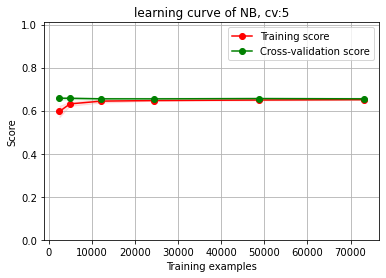

In [11]:
plot_curve_single(train_f1,'NB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [12]:
test_model(train_f1,'LR')

LR total AUC: 0.6653536857862119
LR Coupon AUC: 0.5381247642711647


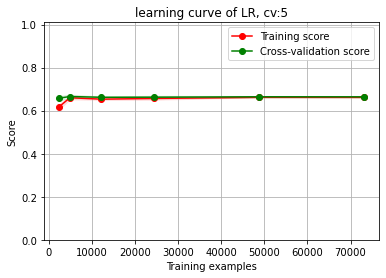

In [13]:
plot_curve_single(train_f1,'LR',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [14]:
test_model(train_f1,'KNN')

KNN total AUC: 0.5166435596945809
KNN Coupon AUC: 0.49904952962648


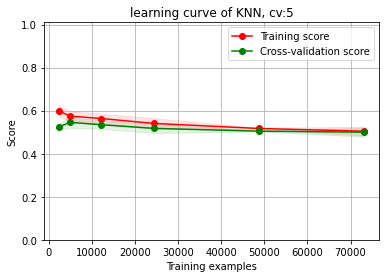

In [15]:
plot_curve_single(train_f1,'KNN',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [16]:
test_model(train_f1,'DT')

DT total AUC: 0.6481607651168957
DT Coupon AUC: 0.5302514392404754


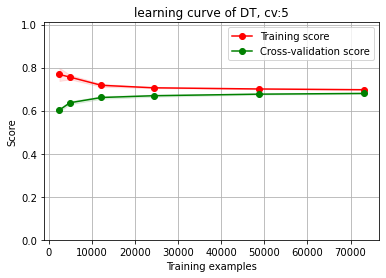

In [17]:
plot_curve_single(train_f1,'DT',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [18]:
test_model(train_f1,'RF')

RF total AUC: 0.6526425714358289
RF Coupon AUC: 0.529893528582881


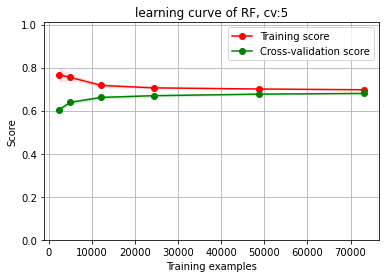

In [19]:
plot_curve_single(train_f1,'RF',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [20]:
test_model(train_f1,'GBDT')

GBDT total AUC: 0.6566796421010357
GBDT Coupon AUC: 0.533503980409598


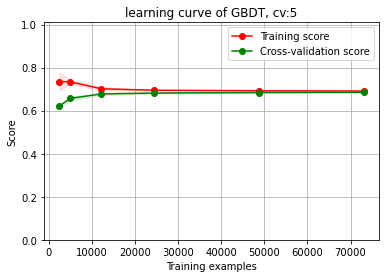

In [21]:
plot_curve_single(train_f1,'GBDT',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [22]:
test_model(train_f1,'LGB')

LGB total AUC: 0.6534077718076291
LGB Coupon AUC: 0.5327884933599097


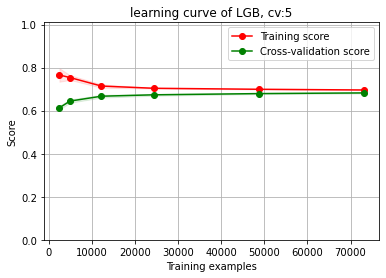

In [23]:
plot_curve_single(train_f1,'LGB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [24]:
test_model(train_f1,'XGB')

XGB total AUC: 0.6537138075207527
XGB Coupon AUC: 0.531849037296699


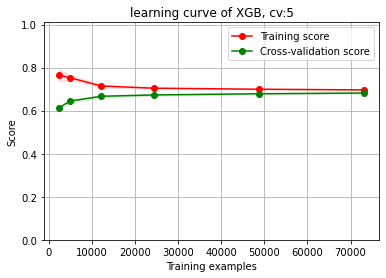

In [25]:
plot_curve_single(train_f1,'XGB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [26]:
train_f2,test_f2 = read_data('sf2')
train_f2,test_f2 = standize_df(train_f2,test_f2)

train_f3,test_f3 = read_data('sf3')
train_f3,test_f3 = standize_df(train_f3,test_f3)


In [27]:
train_f3.head()

,discount_rate,distance,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,total_coupon,merchant_distance_min,merchant_distance_max,...,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,0.037988,0.043496,0.214299,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,0.302988,0.392295,0.209746,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,9871,20160409


In [28]:
print('f1 naive Bayes AUC')
test_model(train_f1,'NB')
print('sf2 naive Bayes AUC')
test_model(train_f2,'NB')
print('sf3 naive Bayes AUC')
test_model(train_f3,'NB')

f1 naive Bayes AUC
NB total AUC: 0.6670944091690476
NB Coupon AUC: 0.5381247642711647
sf2 naive Bayes AUC
NB total AUC: 0.7344423161179449
NB Coupon AUC: 0.6063348615415269
sf3 naive Bayes AUC
NB total AUC: 0.7812536833968516
NB Coupon AUC: 0.7119101385059943


In [29]:
print('f1 logistic regression AUC')
test_model(train_f1,'LR')
print('sf2 logistic regression AUC')
test_model(train_f2,'LR')
print('sf3 logistic regression AUC')
test_model(train_f3,'LR')

f1 logistic regression AUC
LR total AUC: 0.6653536857862119
LR Coupon AUC: 0.5381247642711647
sf2 logistic regression AUC
LR total AUC: 0.7603282848657191
LR Coupon AUC: 0.6029717296152599
sf3 logistic regression AUC
LR total AUC: 0.8100287812776621
LR Coupon AUC: 0.7290104334822116


In [30]:
print('f1 decision tree AUC')
test_model(train_f1,'DT')
print('sf2 decision tree AUC')
test_model(train_f2,'DT')
print('sf3 decision tree AUC')
test_model(train_f3,'DT')

f1 decision tree AUC
DT total AUC: 0.6481735302350922
DT Coupon AUC: 0.5303272197800327
sf2 decision tree AUC
DT total AUC: 0.5214572313721121
DT Coupon AUC: 0.5184907780336148
sf3 decision tree AUC
DT total AUC: 0.5598455688789917
DT Coupon AUC: 0.573055928024194


In [31]:
print('f1 random forest AUC')
test_model(train_f1,'RF')
print('sf2 random forest AUC')
test_model(train_f2,'RF')
print('sf3 random forest AUC')
test_model(train_f3,'RF')

f1 random forest AUC
RF total AUC: 0.6479245459478368
RF Coupon AUC: 0.529819115769599
sf2 random forest AUC
RF total AUC: 0.6829655849834128
RF Coupon AUC: 0.5668258858480313
sf3 random forest AUC
RF total AUC: 0.7713075384714156
RF Coupon AUC: 0.7076433379954025


In [32]:
print('f1 GBDT AUC')
test_model(train_f1,'GBDT')
print('sf2 GBDT AUC')
test_model(train_f2,'GBDT')
print('sf3 GBDT AUC')
test_model(train_f3,'GBDT')

f1 GBDT AUC
GBDT total AUC: 0.6566794918883956
GBDT Coupon AUC: 0.533503980409598
sf2 GBDT AUC
GBDT total AUC: 0.7828266368131885
GBDT Coupon AUC: 0.6035242735877948
sf3 GBDT AUC
GBDT total AUC: 0.8242388479789475
GBDT Coupon AUC: 0.7376404060066872


In [33]:
print('f1 LightGBM AUC')
test_model(train_f1,'LGB')
print('sf2 LightGBM AUC')
test_model(train_f2,'LGB')
print('sf3 LightGBM AUC')
test_model(train_f3,'LGB')

f1 LightGBM AUC
LGB total AUC: 0.6534077718076291
LGB Coupon AUC: 0.5327884933599097
sf2 LightGBM AUC
LGB total AUC: 0.7741029767659218
LGB Coupon AUC: 0.5984526360012944
sf3 LightGBM AUC
LGB total AUC: 0.8284887876924993
LGB Coupon AUC: 0.7374344321731373


In [34]:
print('f1 XGBoost AUC')
test_model(train_f1,'XGB')
print('sf2 XGBoost AUC')
test_model(train_f2,'XGB')
print('sf3 XGBoost AUC')
test_model(train_f3,'XGB')

f1 XGBoost AUC
XGB total AUC: 0.6537138075207527
XGB Coupon AUC: 0.531849037296699
sf2 XGBoost AUC
XGB total AUC: 0.7274131700360452
XGB Coupon AUC: 0.5886899184606202
sf3 XGBoost AUC
XGB total AUC: 0.7973908059790942
XGB Coupon AUC: 0.7290342232690418


In [35]:
train_f3.head()

,discount_rate,distance,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,total_coupon,merchant_distance_min,merchant_distance_max,...,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,0.037988,0.043496,0.214299,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,0.302988,0.392295,0.209746,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,9871,20160409


In [36]:
# predict function
def classifier_df_simple(train_feat, test_feat,classifier):
    model = get_sklearn_model(classifier)    
    model.fit(get_predictors_df(train_feat), get_target_df(train_feat))    
    predicted = pd.DataFrame(model.predict_proba(get_predictors_df(test_feat))[:,1])
    return predicted

# output function
def output_predicted(predicted,resultfile,test_feat):
    predicted = round(predicted,3)
    resultdf = get_id_df(test_feat).copy()
    resultdf['Probability'] = predicted
    return resultdf
    

In [37]:
predicted = classifier_df_simple(train_f3, test_f3,'LGB')

In [38]:
predicted.head()

,0
0,0.007423
1,0.132002
2,0.006900
3,0.012854
4,0.035856


In [39]:
# output result
result = output_predicted(predicted,'sf3_LGB.csv',test_f3)

In [40]:
result.head()

,user_id,coupon_id,date_received,Probability
0,4129537,9983,20160712,0.007
1,6949378,3429,20160706,0.132
2,2166529,6928,20160727,0.007
3,2166529,1808,20160727,0.013
4,6172162,6500,20160708,0.036


In [41]:
# save result
result.to_csv('sf3_lgb.csv', header = False, index = False, sep = ',')